In [1]:
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In this notebook, I try to measure how many of the tokens used in the question are also in the table (without counting stop words)

In [2]:
df_gpt4 = pd.read_csv(
    "../../models/predictions/gpt4/fewshot_with_reasoning/outdomain_eval_gpt_4_few_shot_with_reasoning_single.csv"
)
df_gpt4.head()

,table,predicted_answer,actual_answer,question
0,"<html><body><table class=""infobox biography vc...",Formula One && Five years before his Super GT ...,Brazil,Where did Jenson Button compete 5 years before...
1,"<html><body><table class=""infobox biography vc...",20 years old && Button began his Formula One c...,20,How old was Jenson Button when he began his pr...
2,"<html><body><table class=""infobox biography vc...",United Kingdom && Jenson Button's nationality ...,England,Which country did Jenson Button participated i...
3,"<html><body><table class=""infobox biography vc...",2000 && He first entered the Australian Grand ...,2000,When did Jenson Button first enter into the Au...
4,"<html><body><table class=""infobox biography vc...",10 years ago && Jenson Button last won the Bra...,10 Years ago (2012),How many years ago did Jenson Button last won ...


In [3]:
stop_words = set(stopwords.words("english"))

df_gpt4.loc[:, "question_without_stopwords"] = df_gpt4["question"].apply(
    lambda y: [w.lower() for w in word_tokenize(y) if w.lower() not in stop_words]
)
df_gpt4.loc[:, "table_lower"] = df_gpt4["table"].str.lower()


In [4]:
def token_in_table(row):
    text = row["table_lower"]
    tokens = row["question_without_stopwords"]
    return [token in text for token in tokens]


df_gpt4.loc[:, "question_in_table"] = df_gpt4.apply(token_in_table, axis=1)

In [5]:
df_gpt4.loc[:, "question_in_table_rel"] = df_gpt4.loc[:, "question_in_table"].apply(
    sum
) / df_gpt4.loc[:, "question_in_table"].apply(len)

<Axes: ylabel='Frequency'>

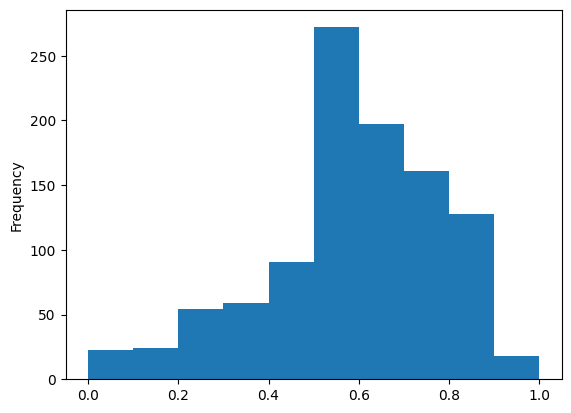

In [6]:
df_gpt4.loc[:, "question_in_table_rel"].plot(kind="hist")

In [7]:
df_gpt4 = df_gpt4.assign(
    predicted_answer_short=lambda x: x["predicted_answer"]
    .str.split("&&")
    .str[0]
    .str.strip(),
    exact_match=lambda x: x.loc[:, "actual_answer"]
    == x.loc[:, "predicted_answer_short"],
)

In the following, I investigate if overlap of words in question and table increase the chance of an exact match between actual and predicted answer.

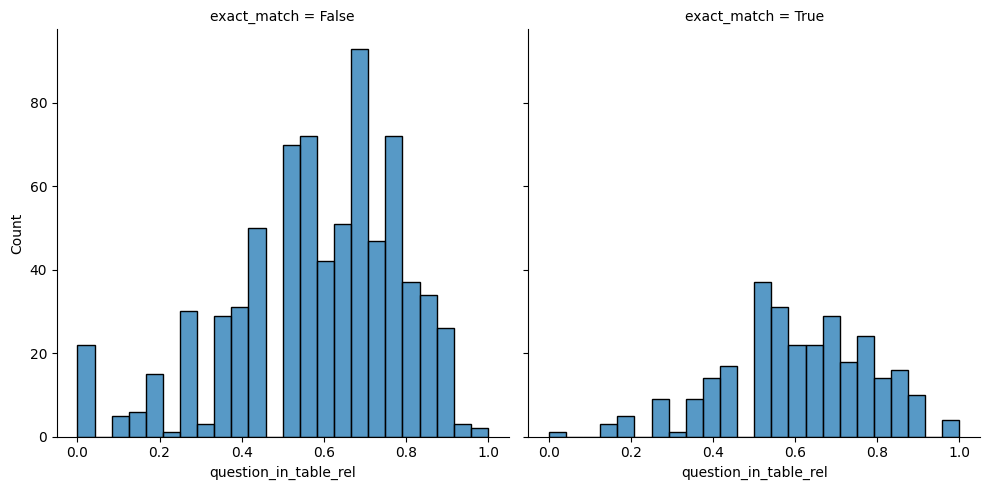

In [8]:
sns.displot(
    df_gpt4,
    x="question_in_table_rel",
    col="exact_match",
    stat="count",
)

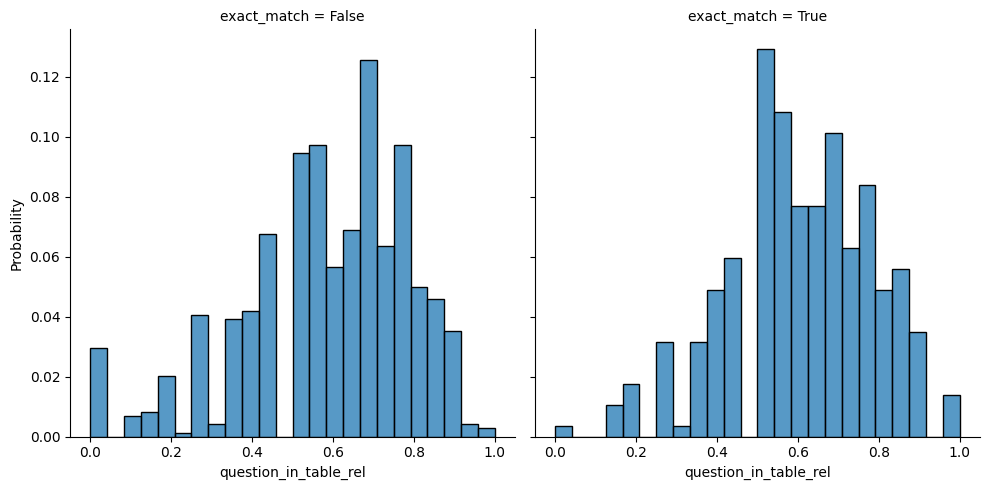

In [9]:
sns.displot(
    df_gpt4,
    x="question_in_table_rel",
    col="exact_match",
    stat="probability",
    common_norm=False,
)